# Segmentando o ventrículo esquerdo com a rede U-Net

Nesta aplicação a rede U-Net é utilizada como segmentadora do ventrículo esquerdo do coração.

A tarefa de segmentação é um dos passos para uma solução para a competição do Kaggle "Second Annual Data Science Bowl" (https://www.kaggle.com/c/second-annual-data-science-bowl)

O dataset utilizado (https://github.com/juliandewit/kaggle_ndsb2/tree/master/data_segmenter_trainset) foi gerado pelo terceiro colocado na competição e contém **11323 imagens e 11323 segmentos** de 184x184 pixels gerados manualmente.

A rede é treinada com a imagem do ventrículo esquerdo do coração coo entrada e a máscara da área segmentada como saída.

O notebook é organizado da seguinte forma:
- importação das bibliotecas
- leitura e tratamento do dataset
- criação da rede
- treinamento da rede
- avaliação da rede com imagens de diversos tamanhos

## Importação das bibliotecas

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# image and file libs
from PIL import Image
import IPython.display
from pandas.io.parsers import read_csv

# from os
import os.path

# from torch
import torch
from torch import nn
from torch.autograd import Variable

# from torchvision
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# from course libs
import lib.pytorch_trainer as ptt

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Leitura do Dataset

### Classe do dataloader

In [3]:
class SegmenterDataset(Dataset):
    def __init__(self, root_dir, demo=True, split=None, transform=None):
        self.image_dir = os.path.join(root_dir, "image")
        self.segment_dir = os.path.join(root_dir, "segment")
        if demo:
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image_demo.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment_demo.csv"), header=None).T
        elif split == "Train":
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image_train.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment_train.csv"), header=None).T
        elif split == "Validate":
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image_validate.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment_validate.csv"), header=None).T
        else:
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment.csv"), header=None).T
        self.image_list = self.image_list.as_matrix().reshape(-1,)
        self.segment_list = self.segment_list.as_matrix().reshape(-1,)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        segment_name = self.segment_list[idx]
        image_path = os.path.join(self.image_dir, image_name)
        segment_path = os.path.join(self.segment_dir, segment_name)

        image = Image.open(image_path)
        segment = Image.open(segment_path)

        if self.transform:
            image = self.transform(image)
            segment = self.transform(segment)

        return image, segment

### Carregando dados de exemplo

In [4]:
# diretório dos dados
dataset_dir = '/data/datasets/heart_image_segmenter/'

segmenter_dataset = SegmenterDataset(dataset_dir, transform=transforms.ToTensor())

### Mostrando algumas imagens do conjunto de treinamento

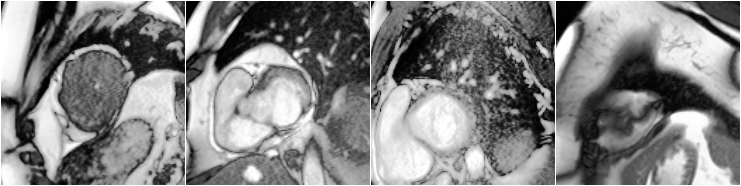

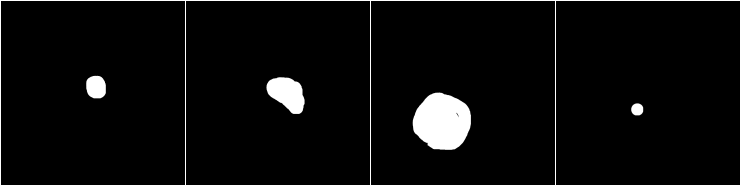

In [5]:
n_samples = 4
tensor2pil = transforms.ToPILImage()

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(segmenter_dataset, 
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, masks = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)
img_pil = tensor2pil(grid)
IPython.display.display(img_pil)
# cria um grid com as máscaras
grid = torchvision.utils.make_grid(masks, normalize=True, pad_value=1.0, padding=1)
img_pil = tensor2pil(grid)
IPython.display.display(img_pil)

In [6]:
del segmenter_dataset
del temp_dataloader

### Criando DataLoader para o treinamento da rede

In [7]:
batch_size = 5

train_segmenter_dataset = SegmenterDataset(
                            dataset_dir,
                            demo=False, split="Train",
                            transform=transforms.ToTensor())

train_segmenter_loader = torch.utils.data.DataLoader(
                                        train_segmenter_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        pin_memory=True)

validate_segmenter_dataset = SegmenterDataset(
                            dataset_dir,
                            demo=False, split="Validate",
                            transform=transforms.ToTensor())

validate_segmenter_loader = torch.utils.data.DataLoader(
                                        validate_segmenter_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        pin_memory=True)

## Criação da rede

<img src='../figures/u-net-architecture.png', width=900pt></img>

O U-Net é uma arquitetura de rede convolucional para segmentação rápida e precisa de imagens. Mais detalhes podem ser vistos em https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [8]:
import torch.nn.functional as F

class ConvBlock(torch.nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_size, out_size, kernel_size,
                              padding=padding, stride=stride)
        self.bn = torch.nn.BatchNorm2d(out_size)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# classe UNet
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_1 = torch.nn.Sequential(
            ConvBlock(1, 16),
            ConvBlock(16, 32, stride=2, padding=1))

        self.down_2 = torch.nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 128))

        self.middle = ConvBlock(128, 128, kernel_size=1, padding=0)

        self.up_2 = torch.nn.Sequential(
            ConvBlock(256, 128),
            ConvBlock(128, 32))

        self.up_1 = torch.nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 32))

        self.output = torch.nn.Sequential(
            ConvBlock(32, 16),
            ConvBlock(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        out = F.upsample(out, scale_factor=2)
        return self.output(out)

### Rede U-Net

In [9]:
model_segmenter = UNet()
if use_gpu:
    model_segmenter.cuda()

### Sumário da rede

In [10]:
print(model_segmenter)

UNet(
  (down_1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
  )
  (down_2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
  )
  (middle): ConvBlock(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1

## Treinamento

### Criando o objeto de treinamento

In [11]:
optimizer = torch.optim.Adam(model_segmenter.parameters())
criterion = nn.MSELoss()
savebest = ptt.ModelCheckpoint('../../models/model_segmenter',reset=True, verbose=1)

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
    model       = model_segmenter,
    criterion   = criterion, 
    optimizer   = optimizer,
    callbacks   = [ptt.PrintCallback(),savebest]
)

In [28]:
train = False
if train:
    trainer.fit_loader(25, train_data=train_segmenter_loader, valid_data=validate_segmenter_loader)
else:
    trainer.load_state('/data/models/model_segmenter')

Treinamento em uma GPU Nvidia Geforce 1080Ti:

    Start training for 25 epochs
      1:  36.6s   T: 0.01141   V: 0.00903 best
      2:  36.1s   T: 0.00590   V: 0.00535 best
      3:  35.9s   T: 0.00487   V: 0.00506 best
      4:  36.0s   T: 0.00431   V: 0.00474 best
      5:  36.0s   T: 0.00393   V: 0.00498 
      6:  36.0s   T: 0.00364   V: 0.00462 best
      7:  36.1s   T: 0.00338   V: 0.00543 
      8:  36.1s   T: 0.00322   V: 0.00450 best
      9:  35.9s   T: 0.00306   V: 0.00431 best
     10:  36.1s   T: 0.00295   V: 0.00477 
     11:  36.0s   T: 0.00279   V: 0.00427 best
     12:  36.0s   T: 0.00269   V: 0.00419 best
     13:  36.0s   T: 0.00261   V: 0.00412 best
     14:  35.9s   T: 0.00247   V: 0.00455 
     15:  36.0s   T: 0.00242   V: 0.00412 
     16:  35.9s   T: 0.00234   V: 0.00455 
     17:  35.9s   T: 0.00224   V: 0.00437 
     18:  35.9s   T: 0.00217   V: 0.00498 
     19:  35.9s   T: 0.00210   V: 0.00428 
     20:  35.9s   T: 0.00206   V: 0.00459 
     21:  35.9s   T: 0.00197   V: 0.00429 
     22:  35.9s   T: 0.00194   V: 0.00440 
     23:  36.0s   T: 0.00187   V: 0.00453 
     24:  35.9s   T: 0.00185   V: 0.00463 
     25:  36.0s   T: 0.00179   V: 0.00423 
    Stop training at epoch: 25/25
    Best model was saved at epoch 13 with loss 0.00412: ../../models/model_segmenter

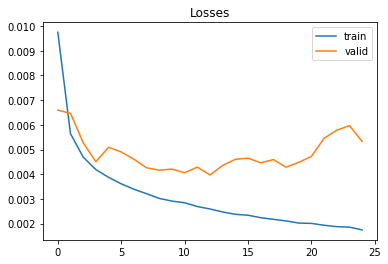

In [13]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, valid_loss, label='valid')
plt.legend()
plt.title('Losses')
plt.show()

## Avaliação

### Prevendo saída do conjunto de testes

In [29]:
n_samples = 4
segmenter_dataset = SegmenterDataset(dataset_dir, transform=transforms.ToTensor())
segmenter_loader = torch.utils.data.DataLoader(
                                        segmenter_dataset,
                                        batch_size=n_samples,
                                        shuffle=False,
                                        pin_memory=True)

In [30]:
prediction = trainer.predict_loader(segmenter_loader) # 40 segundos na AWS

### Transformando saída em máscara binária

In [48]:
prediction_numpy = prediction.numpy()

In [49]:
prediction_mask = np.zeros((prediction_numpy.shape))

In [50]:
threshold = 0.5
prediction_mask[prediction_numpy > threshold] = 1.

### Avaliando qualidade das máscaras

In [34]:
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [44]:
dice_total = 0
for i in range(len(prediction_mask)):
    dice_total += dice_loss(segmenter_dataset[i][1], torch.Tensor(prediction_mask[i]))
dice_total /= len(prediction_mask)

In [45]:
dice_total

0.2708224695166997

### Testando as 4 primeiras amostras do conjunto de teste

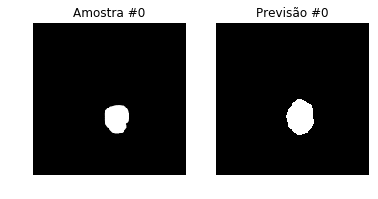

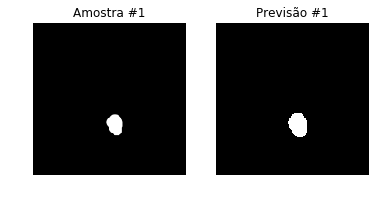

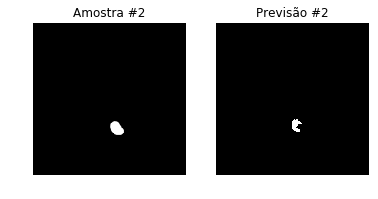

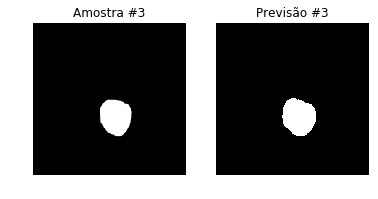

In [22]:
for i in range(4):
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Amostra #'+str(i))
    ax.axis('off')
    plt.imshow(segmenter_dataset[i][1].numpy().squeeze(), cmap='gray')
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Previsão #'+str(i))
    ax.axis('off')
    plt.imshow(prediction_mask[i].squeeze(), cmap='gray')
    plt.show()

### Plot da imagem original do coração com a previsão do segmento

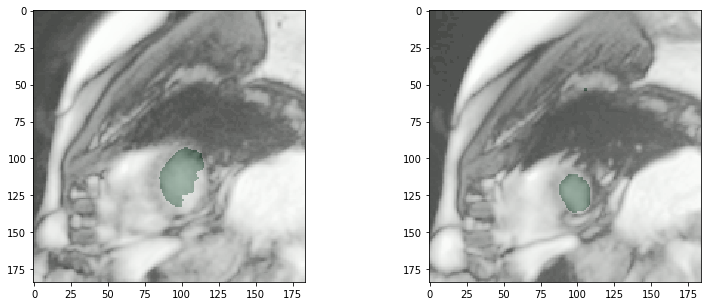

In [51]:
fig = plt.figure(figsize=(13,5))

ax = plt.subplot(1, 2, 1)
plt.imshow(segmenter_dataset[0][0].numpy().squeeze(), cmap='gray')
plt.imshow(prediction_mask[0].squeeze(), cmap='Greens', alpha=0.3)
ax = plt.subplot(1, 2, 2)
plt.imshow(segmenter_dataset[1][0].numpy().squeeze(), cmap='gray')
plt.imshow(prediction_mask[1].squeeze(), cmap='Greens', alpha=0.3)
plt.show()

## Exercícios

## Aprendizados